***
# Energy Model Lab
### Simulation Site: Valença do Douro, Portugal
### Objective: Estimation of Optimal Energy Consumption Timings
***

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Definitions
RENEWABLE_WEIGHT = 2
GRIDPRICE_WEIGHT = 1

***
# Data gathering for the predictive model
***

In [2]:
print(f"[{datetime.now()}] Estimating optimal energy consumption timings with provided data.")
# Load CSV files
grid_price_df = pd.read_csv('output_data/estimated_energy_grid_price.csv')
pv_energy_df = pd.read_csv('output_data/estimated_pv_energy_2.csv')
eolic_energy_df = pd.read_csv('output_data/estimated_wind_energy_2.csv')

[2024-08-17 18:14:42.449923] Estimating optimal energy consumption timings with provided data.


***
# Decision Tree Model
***

In [7]:
# Convert 'datetime' to pandas datetime
grid_price_df['datetime'] = pd.to_datetime(grid_price_df['datetime'], format='%d/%m/%Y %H:%M')
pv_energy_df['datetime'] = pd.to_datetime(pv_energy_df['datetime'], format='%d/%m/%Y %H:%M')
eolic_energy_df['datetime'] = pd.to_datetime(eolic_energy_df['datetime'], format='%d/%m/%Y %H:%M')

# Merge dataframes on 'datetime'
energy_model_df = pd.merge(grid_price_df, pv_energy_df, on='datetime')
energy_model_df = pd.merge(energy_model_df, eolic_energy_df, on='datetime')

# Testing feature
#energy_model_df['eolic_energy'] = 0
#energy_model_df['pv_energy'] = 0

# Merging renewable energy produced and drop separated values
energy_model_df['renewable_energy'] = energy_model_df['pv_energy'] + energy_model_df['eolic_energy']
energy_model_df.drop(columns=['pv_energy', 'eolic_energy'], inplace=True)

# Set datetime as index
energy_model_df.set_index('datetime', inplace=True)

# Normalize the data to range from 0 to 1 per day function
scaler = MinMaxScaler()
def normalize_per_day(group):
    group[['grid_price', 'renewable_energy']] = scaler.fit_transform(group[['grid_price', 'renewable_energy']])
    return group

# Apply normalization within each day
energy_model_df = energy_model_df.groupby(energy_model_df.index.date).apply(normalize_per_day)
energy_model_df.reset_index(inplace=True)
energy_model_df.drop(columns=['level_0'], inplace=True)

# Heuristic for optimal time (example: combining low grid_price with high energy production)
energy_model_df['optimal_score'] = GRIDPRICE_WEIGHT * (1 - energy_model_df['grid_price']) + RENEWABLE_WEIGHT * energy_model_df['renewable_energy']

# Normalizing the 'optimal_score' to range 0 to 1
energy_model_df['optimal_score'] = scaler.fit_transform(energy_model_df[['optimal_score']])

# Extracting more features from dataset and normalize
energy_model_df['hour'] = energy_model_df['datetime'].dt.hour * energy_model_df['renewable_energy']
energy_model_df['hour'] = scaler.fit_transform(energy_model_df[['hour']])

# Features and labels
features = energy_model_df[['grid_price', 'renewable_energy', 'hour']]
labels = energy_model_df['optimal_score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Adding predictions to the dataframe
energy_model_df['predicted_optimal_score'] = model.predict(features)

# Set 'datetime' as the index
energy_model_df.set_index('datetime', inplace=True)
    
# Change date format to day-month-year hour:minute
energy_model_df.index = energy_model_df.index.strftime('%d/%m/%Y %H:%M')

# Store the data on local csv file
energy_model_df.index.name = 'datetime'
energy_model_df.to_csv((f"output_data/estimated_optimal_energy_consumption.csv"))

# Print the processed DataFrame (debug)
# print(energy_model_df)

# Print information
print(f"[{datetime.now()}] Optimal energy consumption timings have been successfully estimated.")

[2024-08-17 18:15:07.000754] Optimal energy consumption timings have been successfully estimated.


## Estimated Data Analysis

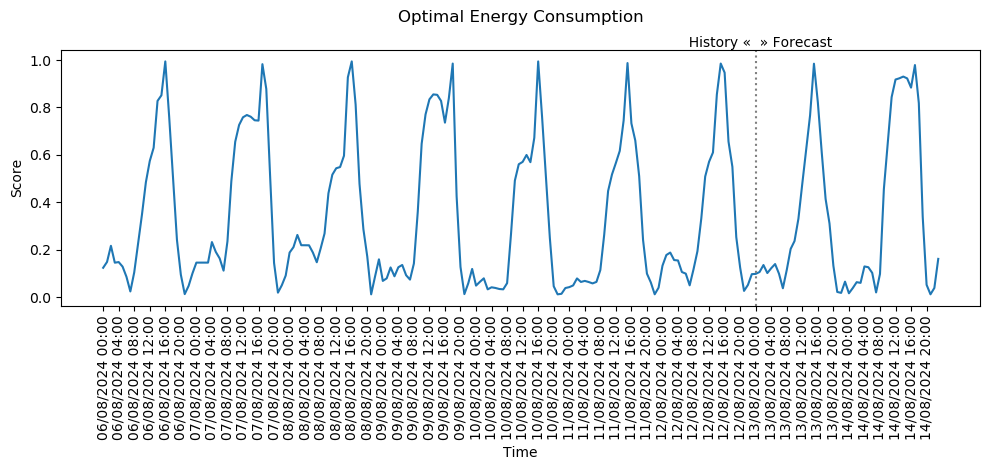

In [8]:
# Translate collumns to name
def score_translation(column):
    if (column == "optimal_score"): param = "Optimal Score"
    if (column == "predicted_optimal_score"): param = "Predicted Optimal Score"
    return param

# Plot Style Function
def applyPlotStyle():
    plt.title(f"Optimal Energy Consumption", pad=20)
    plt.xlabel('Time')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.xticks(range(0, len(energy_model_df), 4))
    plt.tight_layout()
    x_pos = len(energy_model_df)-48
    plt.axvline(x=x_pos, color='gray', linestyle=':')
    y_min, y_pos = plt.ylim()
    plt.text(len(energy_model_df)-48, y_pos, '  History «  » Forecast', va='bottom', ha='center')
    
# Plot energy model optimal energy consumption
plt.figure().set_figwidth(10)
for column in energy_model_df.columns:
    if column in ["predicted_optimal_score"]:
        param = score_translation(column)
        plt.plot(energy_model_df.index.to_numpy(), energy_model_df[column].to_numpy(), label=param)
#plt.legend(loc="upper right")
applyPlotStyle()
plt.savefig(f"output_graphs/estimated_optimal_energy_consumption.png")

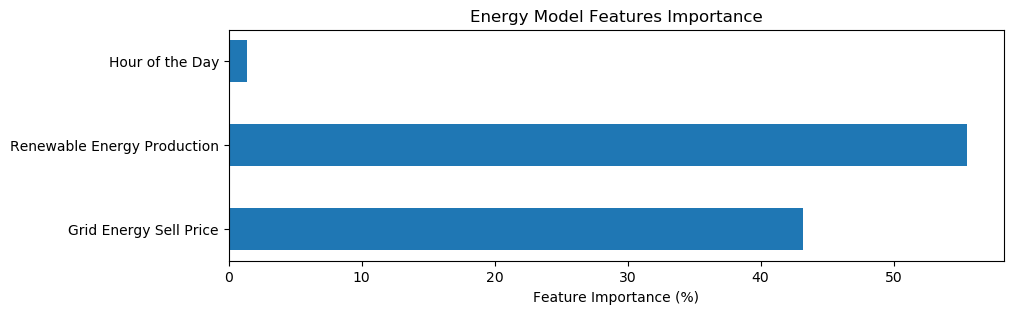

In [9]:
# Get feature importances as percentage
feature_importances = model.feature_importances_ * 100

# Plot feature importances
plt.figure(figsize=(10, 3))
features = ['Grid Energy Sell Price', 'Renewable Energy Production', 'Hour of the Day']
plt.barh(features, feature_importances, height=0.5)
plt.xlabel('Feature Importance (%)')
plt.title('Energy Model Features Importance')
plt.savefig(f"output_graphs/estimated_features_importance.png", bbox_inches = 'tight')